In [1]:
import os
import pandas as pd
from IPython.display import display
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]
import pickle 

from MyTransformers import *
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#%config Completer.use_jedi = False
%matplotlib inline  

f_data_path = "PrepedData/"
f_modele_path = 'Model/'

f_HHData = f_data_path + 'HHDataId/'
mode_path = "Models/"

In [47]:
data = pd.read_feather(f_data_path + "LPG-Profile-4.feather")
data = data['energy'].values
data = np.sum(data.reshape(-1,120),axis=1)
lag = 12*7
init = data[:lag]
#data = data[lag:] - data[:-lag]

In [3]:
def diffInvers(a):
    cc = np.empty(len(a)+lag)
    for i in range(lag):
        cc[i::lag] = np.cumsum(np.concatenate([[init[i]],a[i::lag]]))
    return cc

In [48]:
trainLen = len(data)-200
predLen = 24
train = data[:trainLen]
test = data[trainLen:trainLen+predLen]

## Seasonal

In [28]:
model = ExponentialSmoothing(train,seasonal='mul',seasonal_periods=12*29).fit()
pred = model.predict(start=trainLen,end=trainLen+predLen-1).reshape(-1,1)

c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [49]:
model = ExponentialSmoothing(
    train,
    seasonal_periods=12*7,
    seasonal="add",
    use_boxcox=False,
    initialization_method="estimated",
).fit()
pred = model.predict(start=trainLen,end=trainLen+predLen-1).reshape(-1,1)


In [52]:
prev = model.predict(start=0,end=trainLen).reshape(-1,1)

In [9]:
with open('Results/ExpSmo120In.npy','wb') as f:
    np.save(f,prev)

In [35]:
model.level

array([0.73525143, 0.73478368, 0.73433662, ..., 0.69725356, 0.69794313,
       0.69402881])

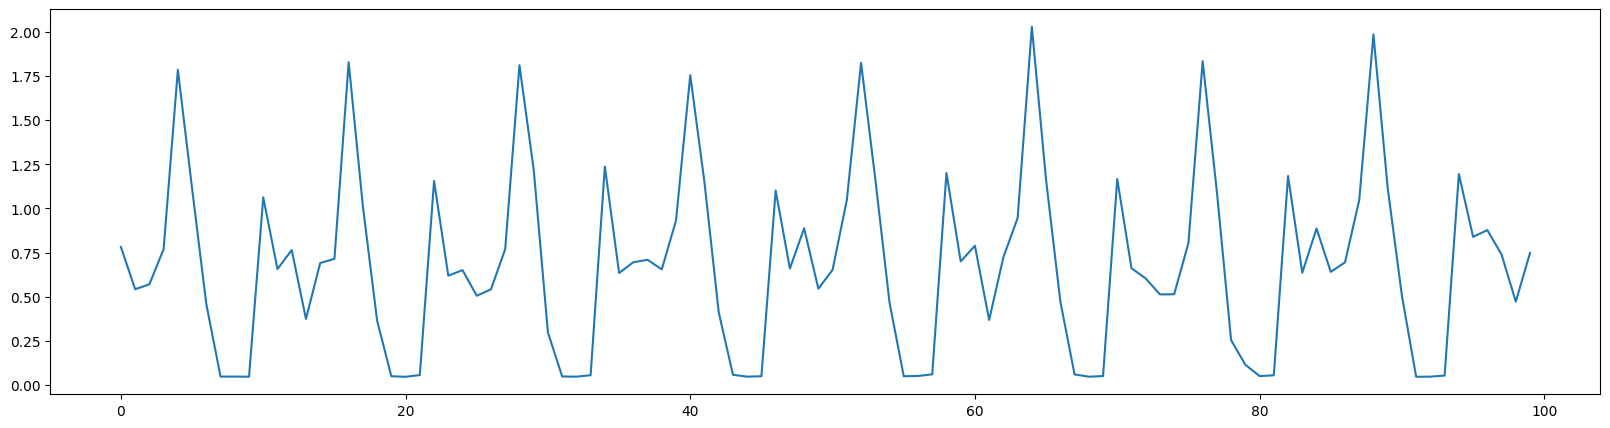

In [13]:
x = model.predict(start=trainLen+1,end=trainLen+100)
plt.plot(x)
with open('Results/expsmootPred100.npy','wb') as f:
    np.save(f,x)

In [30]:
with open('Results/expsmootEndog.npy','wb') as f:
    np.save(f,model.data.endog)

In [8]:
model.params

{'smoothing_level': 0.010034235974984295,
 'smoothing_trend': nan,
 'smoothing_seasonal': 4.214782889525132e-05,
 'damping_trend': nan,
 'initial_level': 0.20585882198634722,
 'initial_trend': nan,
 'initial_seasons': array([0.29883205, 0.26922537, 0.26256965, 4.27714994, 1.27260613,
        0.73818359, 0.7559372 , 0.92215662, 2.45024002, 6.0377101 ,
        3.71409138, 1.4375358 , 0.37394964, 0.23235123, 0.1083513 ,
        3.73090847, 1.36860498, 0.81135845, 0.92125091, 0.99693174,
        2.79281001, 6.41094205, 3.62701391, 1.22257766, 0.43300347,
        0.233752  , 0.06148456, 3.50035535, 1.40851977, 1.07852796,
        1.03715989, 1.24052773, 2.57189152, 5.56694383, 3.35098967,
        1.48757713, 0.23489507, 0.13418921, 0.19318225, 2.50814836,
        4.06063548, 7.42755208, 3.74449482, 4.52283576, 3.04091308,
        3.75946822, 2.72268015, 1.18013519, 0.25561069, 0.25717571,
        0.28555466, 2.0664287 , 3.83957454, 4.3135263 , 3.35238293,
        4.16524524, 2.68093181, 4.1

## Simple

In [79]:
model = SimpleExpSmoothing(train).fit()
pred = model.predict(start=trainLen,end=trainLen+predLen-1).reshape(-1,1)

## Test

In [50]:
# ipred = diffInvers(pred.flatten())[lag:]
# itest = diffInvers(test.flatten())[lag:]
ipred = pred
itest = test
print( "mean_squared_error:", mean_squared_error(itest,ipred))
print("mean_absolute_percentage_error:", mean_absolute_percentage_error(itest,ipred))

mean_squared_error: 0.5183557522474905
mean_absolute_percentage_error: 0.6051573717798056


In [31]:
mse = []
mape = []
for i in range(1,40):
    model = ExponentialSmoothing(train,seasonal='add',seasonal_periods=12*i).fit()
    pred = model.predict(start=trainLen,end=trainLen+predLen-1).reshape(-1,1)
    mse.append(mean_squared_error(test,pred))
    mape.append(mean_absolute_percentage_error(test,pred))
    

c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed

In [36]:
mseAdd = []
mapeAdd = []
for i in range(1,40):
    model = ExponentialSmoothing(train,seasonal='add',seasonal_periods=12*i).fit()
    pred = model.predict(start=trainLen,end=trainLen+predLen-1).reshape(-1,1)
    mseAdd.append(mean_squared_error(test,pred))
    mapeAdd.append(mean_absolute_percentage_error(test,pred))

In [48]:
mseAdd = mse[int(len(mse) / 2):]
mapeAdd = mape[int(len(mse) / 2):]
mape = mape[:int(len(mse) / 2)]
mse = mse[:int(len(mse) / 2)]

In [60]:
with open('Results/expsmootPlotData.npy','wb') as f:
    np.save(f,[mse,mseAdd,mape,mapeAdd])

In [62]:
with open('Results/expsmootPlotData.npy','rb') as f:
    data = np.load(f)

array([[0.58047026, 0.57943041, 0.57205038, 0.57235569, 0.58126801,
        0.58484373, 0.51709449, 0.56338048, 0.56336609, 0.59391241,
        0.57040175, 0.56676992, 0.60814978, 0.53894638, 0.58677921,
        0.60294895, 0.57174968, 0.61484325, 0.58353196, 0.59291627,
        0.52539456, 0.55997979, 0.54661175, 0.60511548, 0.60700221,
        0.59945799, 0.56354799, 0.5338426 , 0.59545122, 0.62770265,
        0.57833518, 0.65331282, 0.52465866, 0.63511621, 0.51166626,
        0.61755622, 0.55860116, 0.61282589, 0.66039231],
       [0.58174203, 0.58127213, 0.57036914, 0.57090645, 0.58377561,
        0.58374421, 0.51835575, 0.56436929, 0.56377598, 0.59976666,
        0.56220223, 0.56753865, 0.61229524, 0.5352481 , 0.59232143,
        0.59498499, 0.57601378, 0.6180889 , 0.58575597, 0.59316241,
        0.53336449, 0.54630626, 0.54599671, 0.60337804, 0.61612101,
        0.60283647, 0.56826676, 0.50366984, 0.5872972 , 0.6304437 ,
        0.56394968, 0.63824681, 0.51324887, 0.6338621 , 0.5

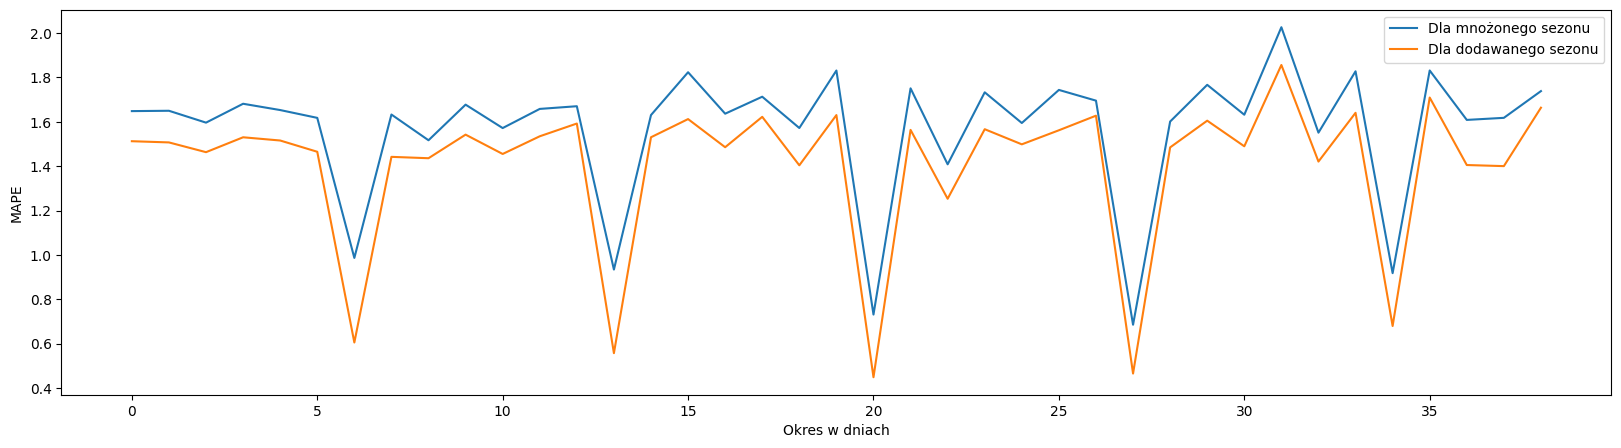

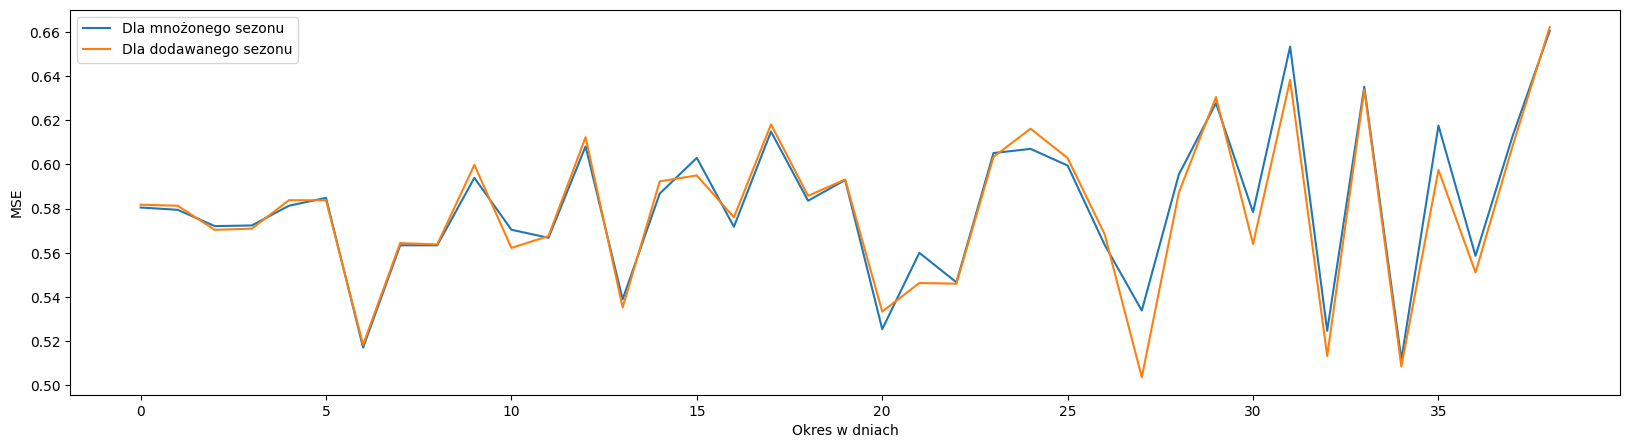

In [54]:
plt.plot(mape)
plt.plot(mapeAdd)
plt.legend(['Dla mnożonego sezonu', 'Dla dodawanego sezonu'])
plt.xlabel("Okres w dniach")
plt.ylabel("MAPE")
plt.figure()
plt.xlabel("Okres w dniach")
plt.ylabel("MSE")
plt.plot(mse)
plt.plot(mseAdd)
plt.legend(['Dla mnożonego sezonu', 'Dla dodawanego sezonu'])

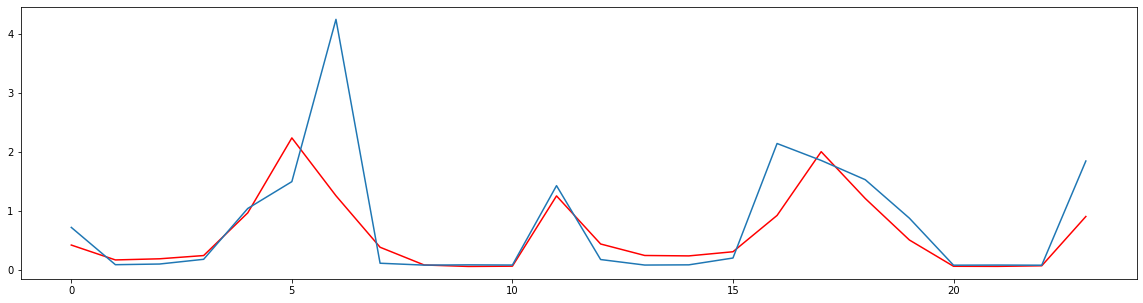

In [10]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ipred,'r')
plt.plot(itest)

0.29950136604474936 0.7224009252593688
0.3548408008374929 0.8775560077941611
0.31877489590762065 0.8663939145005801


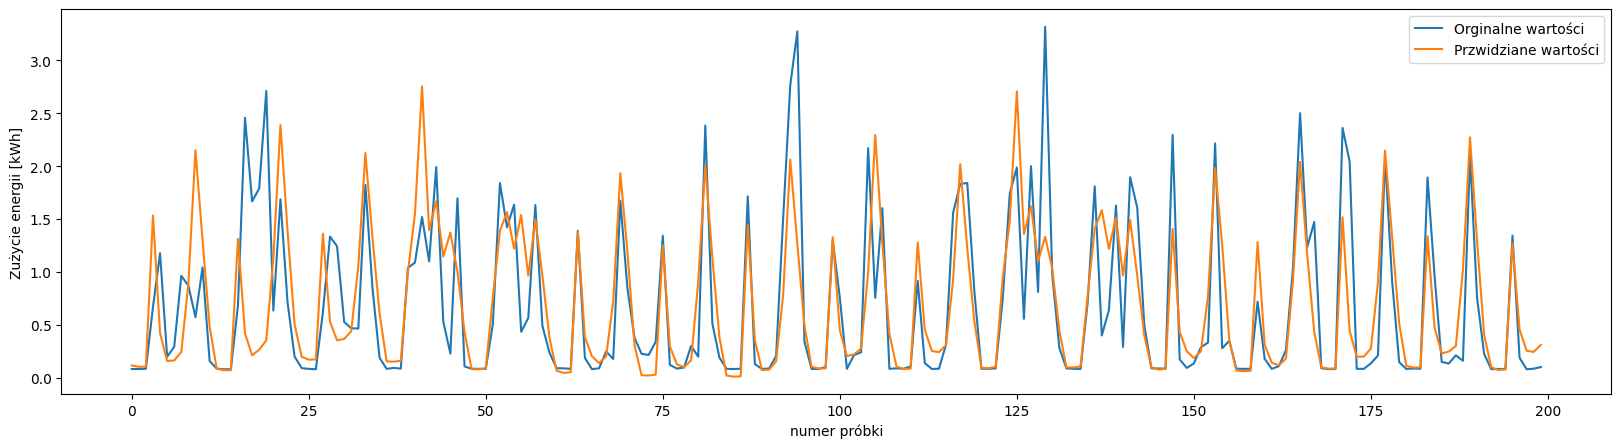

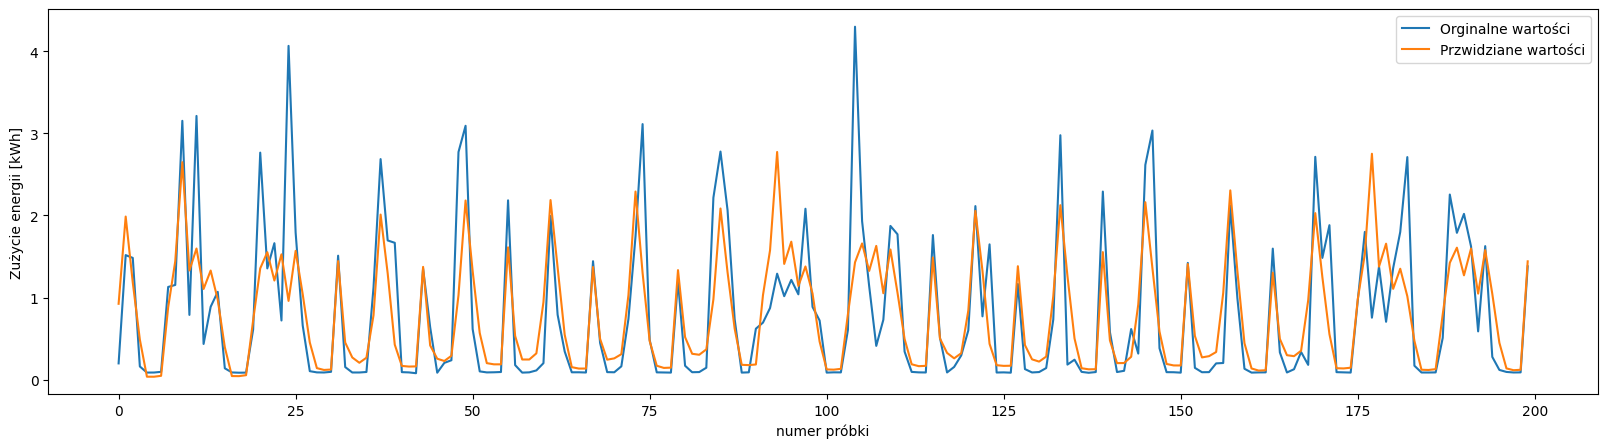

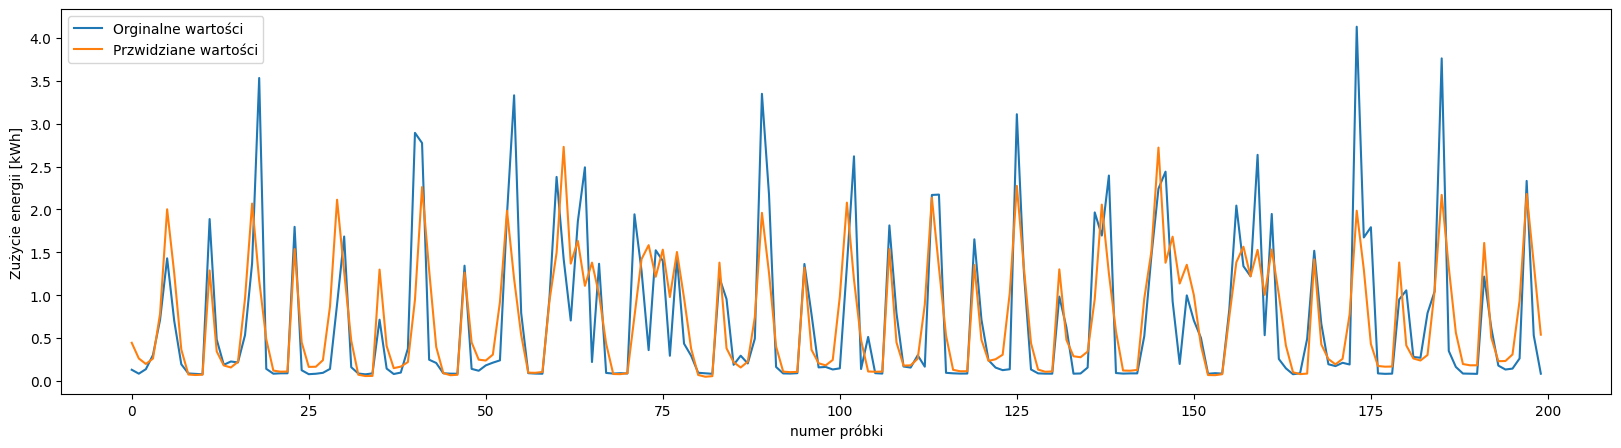

<Figure size 2000x500 with 0 Axes>

In [56]:
# iprev = diffInvers(prev.flatten())[lag:]
# itrain = diffInvers(train.flatten())[lag:]
iprev = prev
itrain = train
for i in range(0,600,200):
    plt.plot(itrain[i:i+200])
    plt.plot(iprev[i:i+200])
    plt.xlabel("numer próbki")
    plt.ylabel("Zużycie energii [kWh]")
    plt.legend(['Orginalne wartości', 'Przwidziane wartości'])
    plt.figure()

    print(mean_squared_error(itrain[i:i+200],iprev[i:i+200]),mean_absolute_percentage_error(itrain[i:i+200],iprev[i:i+200]), mean_squared_error([itrain[i:i+200].sum()],[iprev[i:i+200].sum()]))

In [58]:
data = pd.read_feather(f_data_path + "LPG-Profile-4.feather")
data = data['energy'].values

def testForAgreg(data, agregAmout, seasonal='add'):
    reminder = len(data) % agregAmout
    if(reminder != 0):
        data0 = data[:-reminder]
    else:
        data0 = data
    data0 = np.sum(data0.reshape(-1,agregAmout),axis=1)
    periodday = ((60*24) // agregAmout )
    period = periodday * 7
    #init = data[:lag]

    predLen = periodday * 2
    trainLen = len(data0)-predLen - 1
    train = data0[:trainLen]
    test = data0[trainLen:trainLen+predLen]

    model = ExponentialSmoothing(train,seasonal=seasonal,seasonal_periods=period).fit()
    pred = model.predict(start=trainLen,end=trainLen+predLen-1).reshape(-1,1)
    return (test, pred)

In [66]:
mseAdd = []
mapeAdd = []
msealladd = []
for i in range(30, 60*24, 30):
    print(i)
    test, pred = testForAgreg (data, i,)
    mseAdd.append(mean_squared_error(test,pred))
    msealladd.append(mean_squared_error([test.sum()],[pred.sum()]))
    mapeAdd.append(mean_absolute_percentage_error(test,pred))

mse = []
mape = []
mseall = []
for i in range(30, 60*24, 30):
    #print(i)
    test, pred = testForAgreg (data, i, 'mul')
    mse.append(mean_squared_error(test,pred))
    mseall.append(mean_squared_error([test.sum()],[pred.sum()]))
    mape.append(mean_absolute_percentage_error(test,pred))

30


c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320
1350
1380
1410


c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Jakub\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


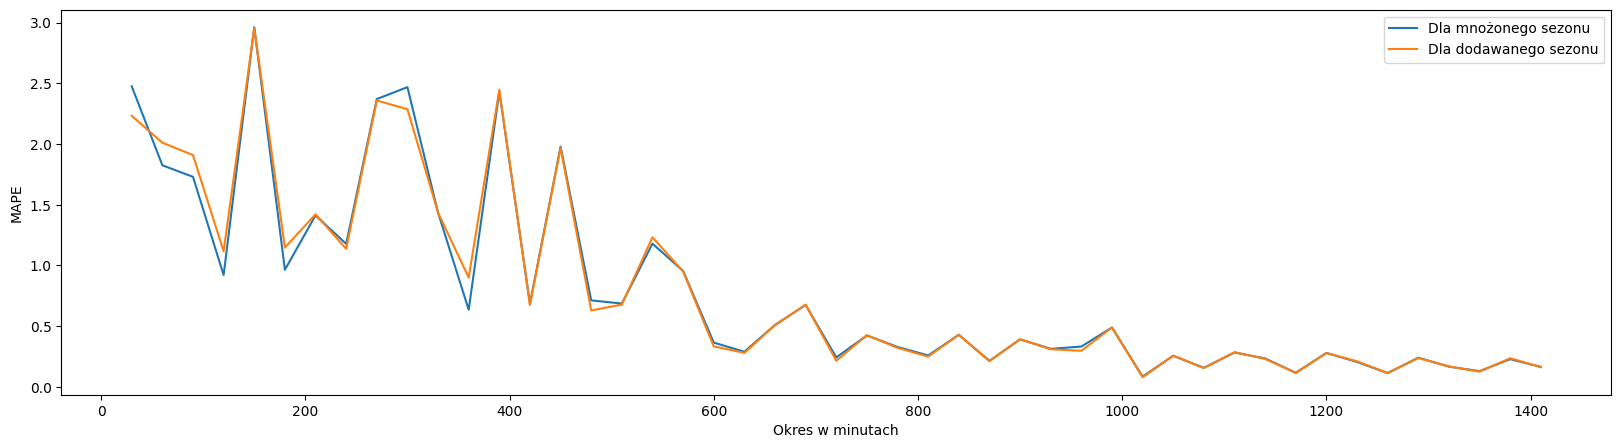

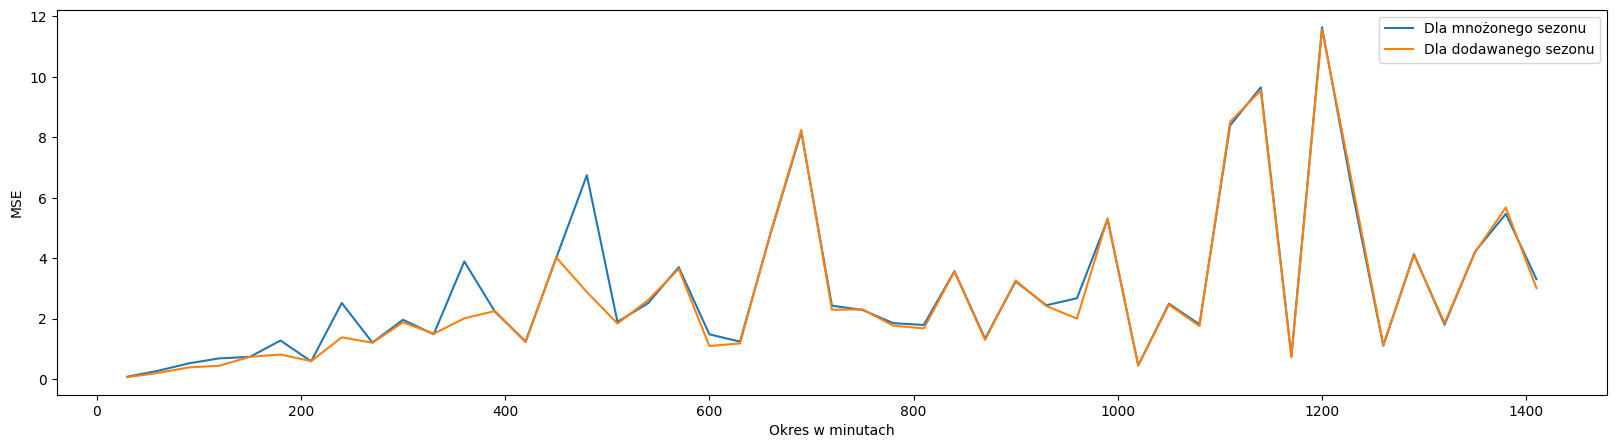

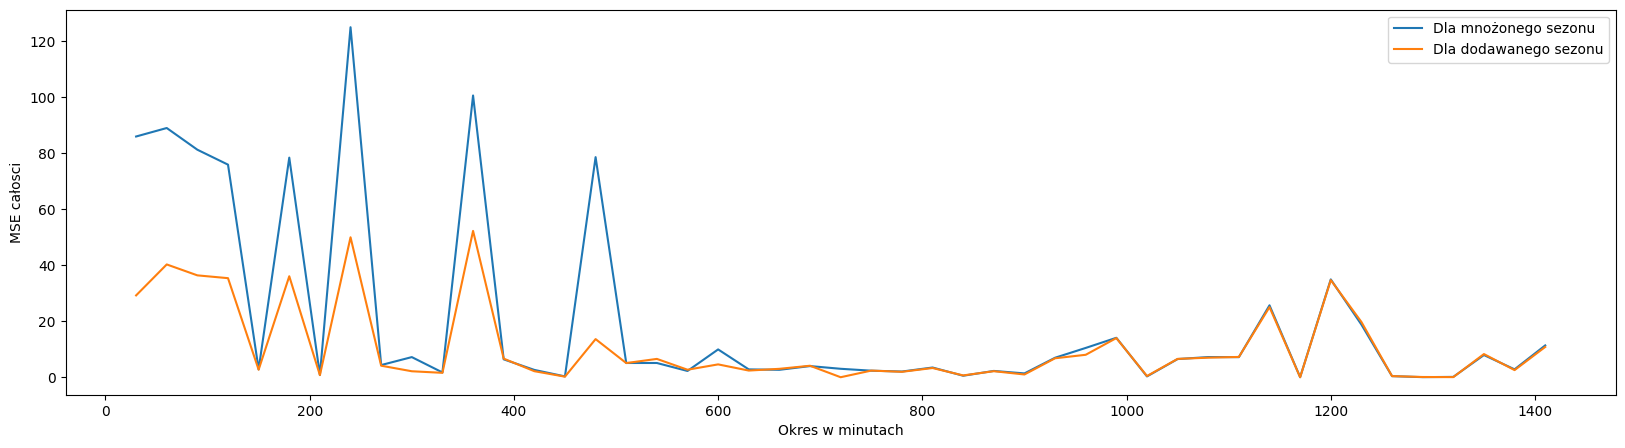

In [67]:
plt.plot(range(30, 60*24, 30),mape)
plt.plot(range(30, 60*24, 30),mapeAdd)
plt.legend(['Dla mnożonego sezonu', 'Dla dodawanego sezonu'])
plt.xlabel("Okres w minutach")
plt.ylabel("MAPE")
plt.figure()
plt.xlabel("Okres w minutach")
plt.ylabel("MSE")
plt.plot(range(30, 60*24, 30),mse)
plt.plot(range(30, 60*24, 30),mseAdd)
plt.legend(['Dla mnożonego sezonu', 'Dla dodawanego sezonu'])
plt.figure()
plt.xlabel("Okres w minutach")
plt.ylabel("MSE całosci")
plt.plot(range(30, 60*24, 30),mseall)
plt.plot(range(30, 60*24, 30),msealladd)
plt.legend(['Dla mnożonego sezonu', 'Dla dodawanego sezonu'])

In [44]:
for i in range(30, 60*24, 30):
    print(i)

30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320
1350
1380
1410
